In [1]:
# Setup
import numpy as np
import tensorflow as tf
from tensorflow import keras

Tranfer learning, or reusing pretrained layers, consists of the following steps:
1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.
5. (OPTIONAL) Fine-tuning, which consists of unfreezing the entire model and re-training on new data with a VERY low learning rate.

## Batch Normalization
## Found on pg. 344 of the textbook for more information!

# Example
## Fine-tuning an image classification model on a cats vs. dogs dataset
This model uses the "Xception" model, pre-trained on "ImageNet", and uses it on the Kaggle "cats vs. dogs" classification dataset.

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True)  # Include labels

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete9CGW1E/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


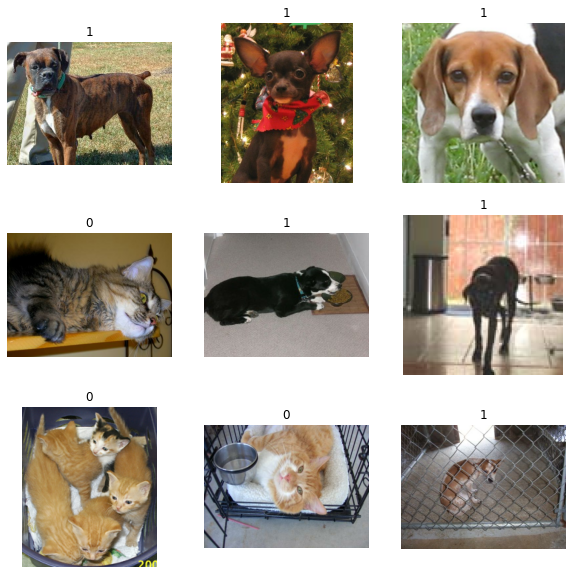

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

## Standardize the data
Each pixel contains 3 integar values between 0 and 255. We will:
1. Standardize to a fixed image size of 150x150
2. Normalize pixel values between -1 and 1, using a "Normalization" layer as part of the model.

In [4]:
# RESIZE THE IMAGES #
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
# BATCH THE DATA #
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

To prevent and slow down any possible overfitting, we will add random changes to images that already exist, such as horizontal flipping or small random rotations, to expose the model to different aspects of the training data.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

This creates the following forms of the first image:

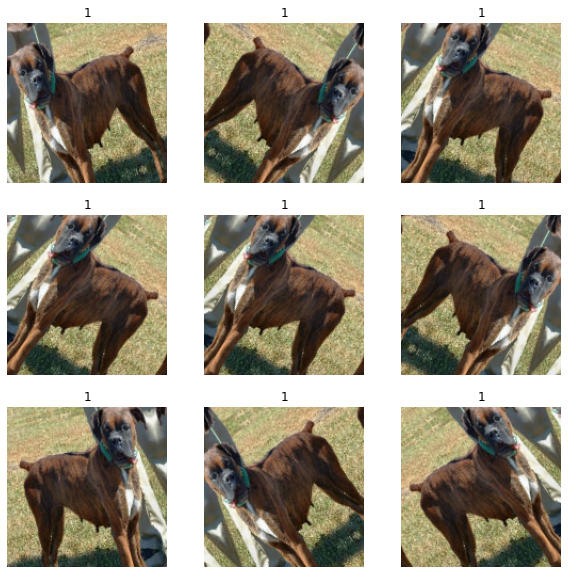

In [7]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Build the Model

In [8]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83697664/83683744 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

## Train the top layer

1. Optimizer is "Adam"
2. Loss Function is Binary Cross Entropy

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 913s 3s/step - loss: 0.0982 - binary_accuracy: 0.9601 - val_loss: 0.0720 - val_binary_accuracy: 0.9733
Epoch 2/20
291/291 [==============================] - 904s 3s/step - loss: 0.0957 - binary_accuracy: 0.9616 - val_loss: 0.0693 - val_binary_accuracy: 0.9725
Epoch 3/20
291/291 [==============================] - 905s 3s/step - loss: 0.0932 - binary_accuracy: 0.9609 - val_loss: 0.0716 - val_binary_accuracy: 0.9712
Epoch 4/20
291/291 [==============================] - 904s 3s/step - loss: 0.0912 - binary_accuracy: 0.9625 - val_loss: 0.0703 - val_binary_accuracy: 0.9721
Epoch 5/20
 69/291 [======>.......................] - ETA: 9:16 - loss: 0.0823 - binary_accuracy: 0.9642

# Visualize Model Performance

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,21))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")